# Scribble visualisation:

#### This Notebook is a visualisation tool:
#### With this notebook you can:
#### - Visualize pathologist annotations
#### - Create scribbles for healthy regions and metastatic regions
#### - Send pathologist annotations and scribbles annotations to cytomine

In [1]:
import sys
sys.path.append('/home/ahabis/2-Scribble_project')

[Errno 2] No such file or directory: '/home/ahabis/Scribble Project'
/home/ahabis/2-Scribble_project


### Libraries to import 

In [4]:
from config import *
from cytomine.models import ProjectCollection
from cytomine import Cytomine
from cytomine.models import CurrentUser
from send_annotation import *
from dell_annotation import delete_annotations
from send_annotation import Send
from scribble_inside_shape import Scribble
import warnings
warnings.filterwarnings('ignore')
pb_key = '868c4bac-e5b8-4758-9b4a-2980571c6bb2'
pv_key = '1476d15a-ec6e-48e0-95ea-d45a0ab0ff94'
host = 'https://nsclc.cytomine.com'

/home/ahabis/.local/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
/home/ahabis/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ahabis/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Image Selection

In [ ]:
### CHOOSE THE IMAGE YOU WANT TO WOR WITH 
filename = 'tumor_016'
#### Write if the image comes from train or test set
split = 'train'
###### CHECK THE ID on CYTOMINE
project = 10355395
image = 10355813
####
if split == 'train':
    path_image = os.path.join(path_slide_tumor_train,filename+'.tif')
else:
    path_image = os.path.join(path_slide_tumor_test,filename+'.tif')

In [ ]:
img = OpenSlide(path_image)

### Visualisation of the Scribble

In [ ]:
s = Scribble(filename,
             percent=0.5,
             interpolation_method = 'cubic',
             show = True,
             split =split)
dataframe_annotation = s.create_dataframe_annotations()

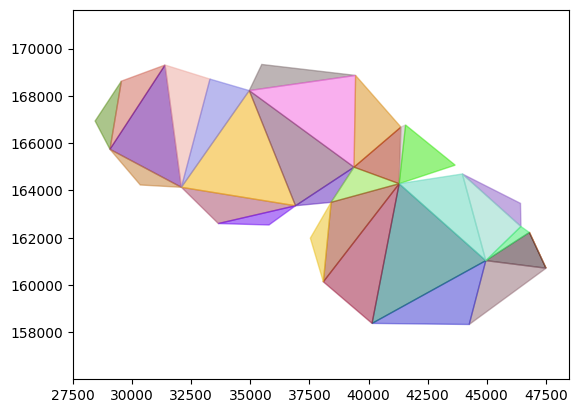

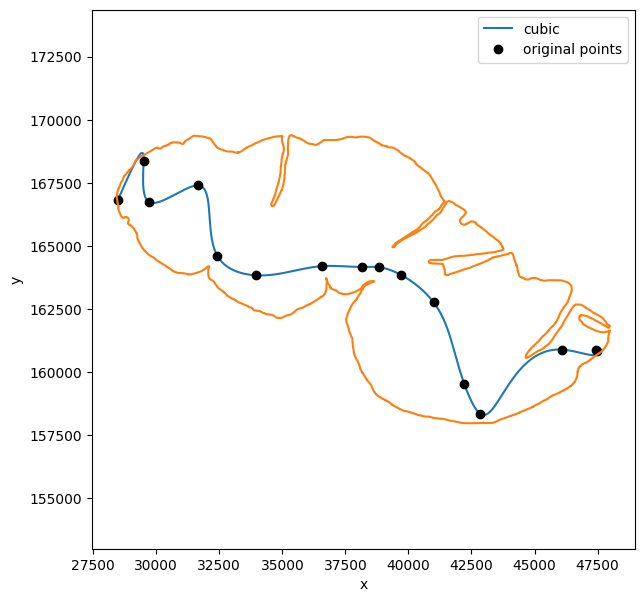

In [ ]:
annotation_id = np.random.choice(dataframe_annotation.columns)
scribble, shape = s.final_scribble(dataframe_annotation,annotation_id)
plt.show()

In [ ]:
def get_scribbles_and_annotations(path_image,
                                  split = split):
    
    slide = Slide(path_image, processed_path='')
    
    mask = TissueMask(
       RgbToGrayscale(),
       OtsuThreshold(),
       ApplyMaskImage(slide.thumbnail),
       GreenPenFilter(),
       RgbToGrayscale(),
       Invert(),
       OtsuThreshold(),
       RemoveSmallHoles(),
       RemoveSmallObjects(min_size =20, avoid_overmask=False )
    )
    sf = 4
    k = np.array(slide.locate_mask(mask, scale_factor=sf,outline='green'))
    k[k==128] = 0
    
    contours,_ = cv2.findContours(k[:,:,3],cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    sizes = np.array([contours[i].shape[0] for i in range(len(contours))])
    r = np.argmax(sizes)
    
    annotation_healthy = contours[r] *sf 
    
    s = Scribble(filename,
                 percent=0.7,
                 show = False,
                 split = split)
    
    dataframe_annotation = s.create_dataframe_annotations()
    scribbles_tumor = []
    annotations_tumor = []
    
    for annotation_id in tqdm(list(dataframe_annotation.columns)):
        
        scribble_tumor, annotation = s.final_scribble(dataframe_annotation,annotation_id)
        
        if scribble_tumor is not(None):
            scribble_tumor = scribble_tumor[s.interpolation_method]
            scribble_tumor =np.expand_dims(scribble_tumor, axis = 1)
            annotation =np.expand_dims(annotation, axis = 1)
            annotations_tumor.append(annotation)
            scribbles_tumor.append(scribble_tumor)

    scribble_healthy = s.scribble_background(annotation_healthy.squeeze())[0][s.interpolation_method]

    return (annotations_tumor ,
            scribbles_tumor,
            annotation_healthy,
            scribble_healthy)

In [ ]:
os.listdir(path_slide_tumor_test)[:6]

['test_122.tif',
 'test_051.tif',
 'test_011.tif',
 'test_008.tif',
 'test_002.tif',
 'test_010.tif']

#### If you want to delete annotations on cytomine 

In [ ]:
# delete_annotations(id_project=project,
#                    id_image = image)

### This code will take the pathologists annotations and generate scribbles and send them to cytomine

In [ ]:
shapes, scribbles, contour_foreground, scribble_foreground = get_scribbles_and_shapes()

NameError: name 'get_scribbles_and_shapes' is not defined

In [ ]:
S = Send(filename)
S.send_annotations_to_cytomine(shapes,
                               scribbles,
                               contour_foreground,
                               scribble_foreground,
                               id_image=image,
                               id_project=project)

INFO:cytomine.client:[GET] /server/ping | 200 OK
INFO:cytomine.client:[GET] [currentuser] CURRENT USER - 10355323 : ahabis | 200 OK
INFO:cytomine.client:[POST] userannotations 23471423 added | 200 OK
INFO:cytomine.client:[POST] userannotations 23471430,23471437 added | 200 OK
INFO:cytomine.client:[POST] userannotations 23471444,23471451,23471458 added | 200 OK
INFO:cytomine.client:[POST] userannotations 23471465,23471472,23471479,23471486 added | 200 OK
INFO:cytomine.client:[POST] userannotations 23471493,23471500,23471507,23471514,23471521 added | 200 OK
INFO:cytomine.client:[POST] userannotations 23471528,23471535,23471542,23471549,23471556,23471563 added | 200 OK
